Wet Season Analysis (November to April): Obtain daily maximum storm surge residual data for these months to analyze the impact of the wet season on storm surge levels. This analysis can help in understanding the potential for flooding during the season when storms are most frequent.

Storm surge residual:
The storm surge residual is calculated as the difference between the total water level and the tidal elevation simulations. The effect of changes in annual mean sea level is included in the simulation in both the historical and future periods.


In [1]:
import os
import xarray as xr

# Define the path to the directory containing the .nc files
data_directory = 'ssr_85_14'

# List all files in the directory
nc_files = [os.path.join(data_directory, file) for file in os.listdir(data_directory) if file.endswith('.nc')]

# Sort files to ensure they are in the correct order
nc_files.sort()

# Read all the netCDF files into a list of xarray datasets
ds_list = [xr.open_dataset(file) for file in nc_files]

# Now you have a list of xarray datasets, each corresponding to one NetCDF file
# If needed, you can combine them into a single dataset using xarray.concat


In [2]:
# combine all the datasets into a single dataset
ds = xr.concat(ds_list, dim='time')

In [3]:
# Print the dataset
print(ds)

<xarray.Dataset>
Dimensions:               (time: 5437, stations: 43119)
Coordinates:
  * time                  (time) datetime64[ns] 1985-01-01 ... 2014-12-31
    station_x_coordinate  (stations) float64 24.09 24.09 26.9 ... 37.75 37.95
    station_y_coordinate  (stations) float64 34.83 34.87 35.37 ... -46.98 -46.63
  * stations              (stations) uint16 0 1 2 3 ... 43730 43731 43732 43733
Data variables:
    surge                 (time, stations) float32 0.024 0.023 ... -0.042 -0.039
Attributes: (12/35)
    Conventions:                   CF-1.6
    featureType:                   timeSeries
    id:                            GTSMv3_surge
    naming_authority:              https://deltares.nl/en
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    title:                         Daily timeseries of surge levels
    ...                            ...
    time_coverage_start:           1985-01-01 00:00:00
    time_coverage_end:             1985-01-31 00:00:00
    exp

In [4]:


# Calculate the monthly maximum surge level for each station
# monthly_max = ds['surge'].resample(time='M').max()

# Print the result
print(monthly_max)


<xarray.DataArray 'surge' (time: 360, stations: 43119)>
array([[0.20500001, 0.209     , 0.216     , ..., 0.08800001, 0.256     ,
        0.24900001],
       [0.32700002, 0.33100003, 0.34300002, ..., 0.209     , 0.15200001,
        0.14500001],
       [0.18800001, 0.18800001, 0.17500001, ..., 0.162     , 0.323     ,
        0.321     ],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.086     , 0.087     , 0.083     , ..., 0.158     , 0.37100002,
        0.37600002],
       [0.11300001, 0.112     , 0.10200001, ..., 0.23200001, 0.38900003,
        0.38200003]], dtype=float32)
Coordinates:
  * stations              (stations) uint16 0 1 2 3 ... 43730 43731 43732 43733
  * time                  (time) datetime64[ns] 1985-01-31 ... 2014-12-31
    station_x_coordinate  (stations) float64 24.09 24.09 26.9 ... 37.75 37.95
    station_y_coordinate  (stations) float64 34.83 34.87 35.37 ... -46.98 -46.63


In [5]:
import pandas as pd


# Assuming 'ds' is your xarray Dataset
# Define the geographical bounds of Australia (approximate)
lon_min, lon_max = 113, 154  # Min and max longitude
lat_min, lat_max = -44, -10  # Min and max latitude

# Filter the dataset for stations within Australian bounds
aus_stations = ds.where((ds.station_x_coordinate >= lon_min) & (ds.station_x_coordinate <= lon_max) & 
                        (ds.station_y_coordinate >= lat_min) & (ds.station_y_coordinate <= lat_max), 
                        drop=True)

# Calculate the monthly maximum surge level for each Australian station
monthly_max_aus = aus_stations['surge'].resample(time='M').max()

# Identify the month and station with the highest surge
max_surge = monthly_max_aus.max(dim='time')
max_surge_time = monthly_max_aus.idxmax(dim='time')

# Convert to DataFrame for easier manipulation and potential visualization
max_surge_df = max_surge.to_dataframe(name='max_surge')
max_surge_time_df = max_surge_time.to_dataframe(name='time_of_max_surge')

# Merge the DataFrames on the station index
extreme_surge_df = pd.merge(max_surge_df, max_surge_time_df, left_index=True, right_index=True)

# Now, extreme_surge_df contains the maximum surge and the time it occurred for each station


In [7]:
# check the data
extreme_surge_df.head()

,station_x_coordinate_x,station_y_coordinate_x,max_surge,station_x_coordinate_y,station_y_coordinate_y,time_of_max_surge
stations,,,,,,
8422,145.063,-40.679,0.535,145.063,-40.679,2003-12-31
8423,145.327,-40.825,0.581,145.327,-40.825,2009-04-30
8424,145.737,-40.942,0.610,145.737,-40.942,2009-04-30
8425,146.118,-41.118,0.634,146.118,-41.118,2009-04-30
8426,146.558,-41.147,0.680,146.558,-41.147,1994-11-30


In [8]:
# Rename columns as specified
extreme_surge_df = extreme_surge_df.rename(columns={
    'station_x_coordinate_x': 'station_x_coordinate',
    'station_y_coordinate_x': 'station_y_coordinate'
})

# Drop unnecessary columns
extreme_surge_df = extreme_surge_df.drop(columns=['station_x_coordinate_y', 'station_y_coordinate_y'])

# Display the cleaned DataFrame
extreme_surge_df.head()


,station_x_coordinate,station_y_coordinate,max_surge,time_of_max_surge
stations,,,,
8422,145.063,-40.679,0.535,2003-12-31
8423,145.327,-40.825,0.581,2009-04-30
8424,145.737,-40.942,0.610,2009-04-30
8425,146.118,-41.118,0.634,2009-04-30
8426,146.558,-41.147,0.680,1994-11-30


In [30]:
extreme_surge_df.tail()

,station_x_coordinate,station_y_coordinate,max_surge,time_of_max_surge
stations,,,,
43693,117.876,-35.112,0.408,2012-11-30
43695,115.591,-20.376,1.041,1996-04-30
43696,115.532,-20.376,0.849,1996-04-30
43697,115.591,-20.435,1.183,1996-04-30
43704,115.562,-20.376,0.977,1996-04-30


In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)

C:\Users\E\AppData\Local\Temp\ipykernel_54572\1607001912.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


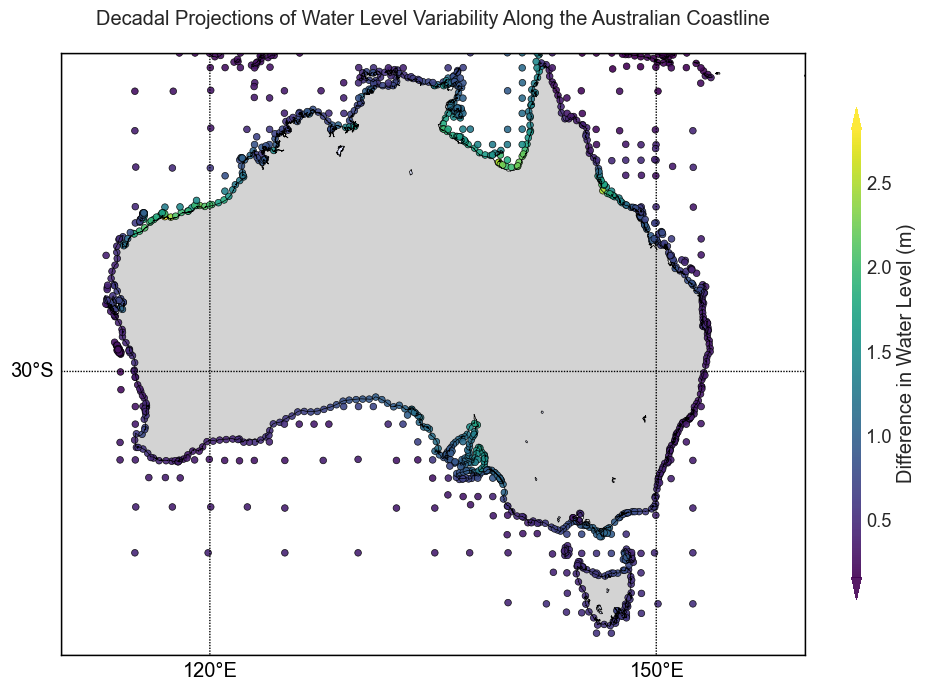

In [45]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd


# Latitude and longitude boundaries for Australia
lat_min, lat_max = -45, -10
lon_min, lon_max = 110, 160

# Create a new figure
plt.figure(figsize=(12, 8))

# Set a style
plt.style.use('seaborn-darkgrid')

# Create a Basemap instance
# Create a Basemap instance zoomed in on Australia
m = Basemap(projection='merc', llcrnrlat=lat_min, urcrnrlat=lat_max, 
            llcrnrlon=lon_min, urcrnrlon=lon_max, resolution='i')

# Draw coastlines, country borders, and fill continents
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=0.5)
m.fillcontinents(color='lightgray', lake_color='#E1E5FF')
m.drawmapboundary(fill_color='#FFFFFF')
m.drawmeridians(np.arange(-180., 181., 30.), labels=[False, False, False, True])
m.drawparallels(np.arange(-90., 91., 30.), labels=[True, False, False, False])

# Convert station coordinates to map projection coordinates
x, y = m(extreme_surge_df['station_x_coordinate'].values, 
         extreme_surge_df['station_y_coordinate'].values)

# Scatter plot
sc = m.scatter(x, y, c=extreme_surge_df['max_surge'],
                     cmap='viridis', edgecolor='k', linewidth=0.5, alpha=0.9)

# Add a horizontal colorbar
cb = plt.colorbar(sc, extend='both', pad=0.05, aspect=50, shrink=0.8)
cb.set_label('Difference in Water Level (m)')

# Add a title with some padding for aesthetics
plt.title('Decadal Projections of Water Level Variability Along the Australian Coastline', pad=20)


# Show the plot
plt.show()


In [33]:


# change the index to column
extreme_surge_df.reset_index(inplace=True)

# check the data
extreme_surge_df.head()

,stations,station_x_coordinate,station_y_coordinate,max_surge,time_of_max_surge
0,8422,145.063,-40.679,0.535,2003-12-31
1,8423,145.327,-40.825,0.581,2009-04-30
2,8424,145.737,-40.942,0.610,2009-04-30
3,8425,146.118,-41.118,0.634,2009-04-30
4,8426,146.558,-41.147,0.680,1994-11-30


In [35]:
# Assuming `df` is your DataFrame with columns 'station_id', 'date', and 'surge_level'
# and it contains multiple time observations for each station.

# Convert 'date' to datetime if it's not already
extreme_surge_df['time_of_max_surge'] = pd.to_datetime(extreme_surge_df['time_of_max_surge'])

# Pivot the DataFrame to get time on the index and stations as columns
time_series_df = extreme_surge_df.pivot(index='time_of_max_surge', columns='stations', values='max_surge')




In [38]:

import matplotlib.pyplot as plt
import pandas as pd

# First, sort the DataFrame by 'max_surge' to find the stations with the highest surges
top_stations = extreme_surge_df.sort_values('max_surge', ascending=False).head(10)

top_stations



,stations,station_x_coordinate,station_y_coordinate,max_surge,time_of_max_surge
224,8945,116.968,-20.610,2.816,1989-04-30
338,9059,139.409,-17.153,2.521,1987-02-28
43,8655,139.438,-17.153,2.481,1987-02-28
386,9107,146.411,-18.970,2.477,2011-02-28
1028,42029,116.909,-20.493,2.469,1989-04-30
225,8946,117.378,-20.640,2.429,1989-04-30
339,9060,139.526,-17.271,2.397,1987-02-28
230,8951,119.312,-19.907,2.284,2007-03-31
608,18380,139.673,-17.329,2.248,1987-02-28
607,18379,140.698,-17.388,2.232,2010-01-31


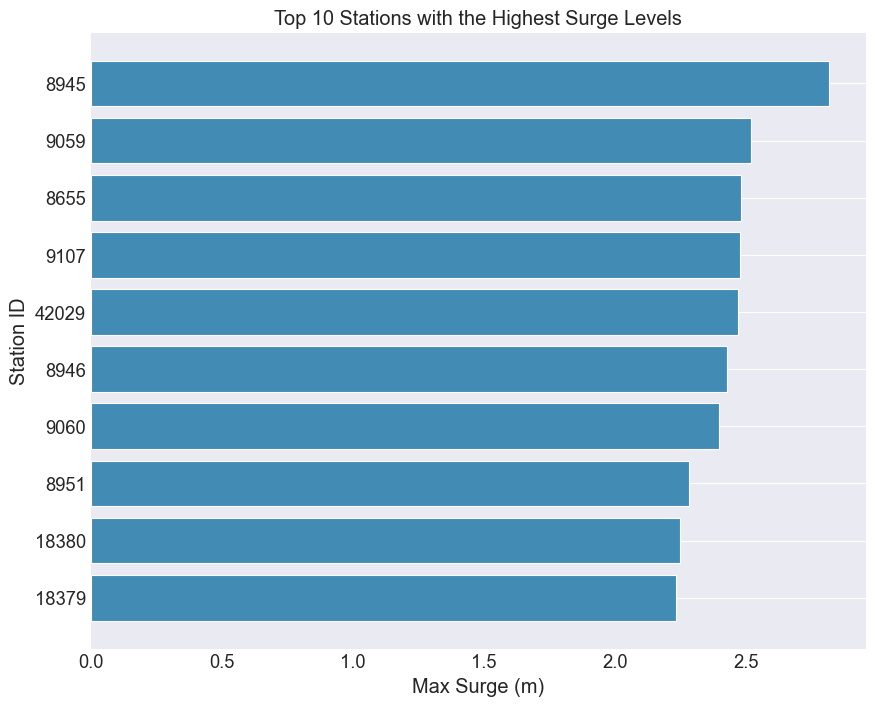

In [48]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `top_stations` is a DataFrame that contains the top 10 stations with the highest surges
# Sort the stations by 'max_surge' in descending order for better visualization
top_stations_sorted = top_stations.sort_values('max_surge', ascending=True)

# Create a horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(top_stations_sorted['stations'].astype(str), top_stations_sorted['max_surge'], color='#428BB4')
plt.xlabel('Max Surge (m)')
plt.ylabel('Station ID')
plt.title('Top 10 Stations with the Highest Surge Levels (1985-2014)')
plt.grid(axis='x')

# Display the bar chart
plt.show()




C:\Users\E\AppData\Local\Temp\ipykernel_54572\2986894602.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


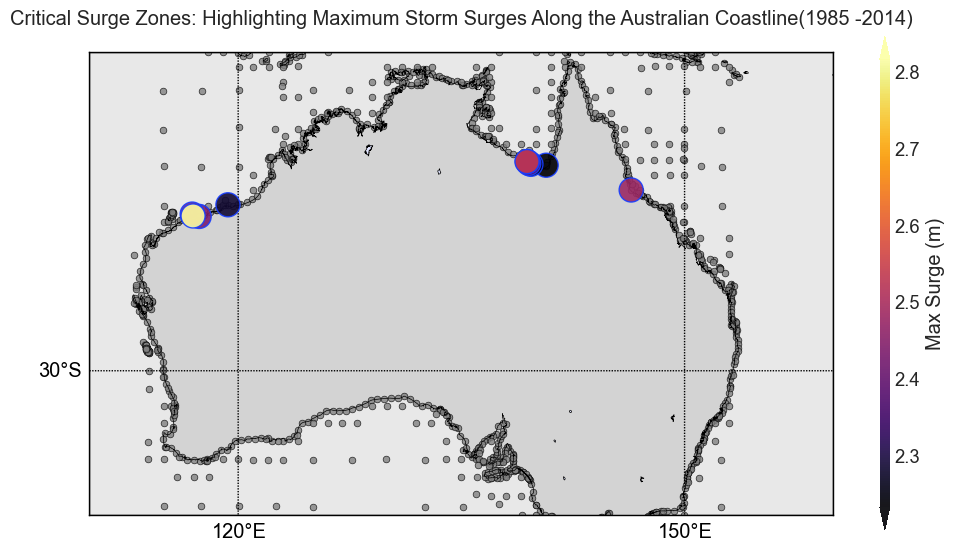

In [63]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np

# Latitude and longitude boundaries for Australia
lat_min, lat_max = -38, -10
lon_min, lon_max = 110, 160

# Create a new figure
plt.figure(figsize=(12, 8))

# Set a style
plt.style.use('seaborn-darkgrid')

# Create a Basemap instance zoomed in on Australia
m = Basemap(projection='merc', llcrnrlat=lat_min, urcrnrlat=lat_max, 
            llcrnrlon=lon_min, urcrnrlon=lon_max, resolution='i')

# Draw coastlines, country borders, and fill continents
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=0.5)
m.fillcontinents(color='lightgray', lake_color='#E1E5FF')
m.drawmapboundary(fill_color='#E8E8E8')
m.drawmeridians(np.arange(-180., 181., 30.), labels=[False, False, False, True])
m.drawparallels(np.arange(-90., 91., 30.), labels=[True, False, False, False])

# Convert station coordinates to map projection coordinates
all_x, all_y = m(extreme_surge_df['station_x_coordinate'].values, 
                 extreme_surge_df['station_y_coordinate'].values)

# Plot all stations
m.scatter(all_x, all_y, c='gray', edgecolor='k', linewidth=0.5, alpha=0.8, zorder=1)

# Highlight the top 10 stations
top_x, top_y = m(top_stations_sorted['station_x_coordinate'].values, 
                 top_stations_sorted['station_y_coordinate'].values)

# Plot top stations with a different color and larger size
m.scatter(top_x, top_y, c=top_stations_sorted['max_surge'], 
          cmap='inferno', edgecolor='#163DFF', linewidth=1, alpha=0.9, zorder=2, s=300)

# Add a colorbar
cb = plt.colorbar(extend='both', pad=0.05, aspect=50, shrink=0.8)
cb.set_label('Max Surge (m)')

# Add a title with some padding for aesthetics
plt.title('Critical Surge Zones: Highlighting Maximum Storm Surges Along the Australian Coastline(1985 -2014)', pad=20)

# Show the plot
plt.show()
